# Rat Tumor Example

This is an R work-through of the rat tumor example in Chapter 5 of *Bayesian Data Analysis*, 3rd Edition (Gelman et al., 2014).

The Git repository containing this notebook contains Conda `environment.yml` files to run it on Linux (64-bit) and Windows.  In addition to the packages in the Conda environment spec, you will also need the following:

-   The [Rust compiler](https://www.rust-lang.org) to compile the optimized log-likelihood function
-   The `rustinr` package from [Rustr](https://rustr.org/); install with `devtools`:

    ```R
    devtools::install_github('rustr/rustinr')
    ```
    
If the environment files aren't working for you (e.g. you're on macOS), the following packages are required:

- r
- r-irkernel
- notebook
- r-ggplot2
- r-plyr
- r-dplyr
- r-doParallel
- r-devtools

## Input Data

First, we need the rat data.  This data originally came from Tarone (1982), and is available from <http://www.stat.columbia.edu/~gelman/book/data/rats.asc>.

In [1]:
rat.data = read.csv("rats.csv")
summary(rat.data)

    Infected          Total      
 Min.   : 0.000   Min.   :10.00  
 1st Qu.: 1.000   1st Qu.:19.00  
 Median : 3.000   Median :20.00  
 Mean   : 3.761   Mean   :24.49  
 3rd Qu.: 5.000   3rd Qu.:22.50  
 Max.   :16.000   Max.   :52.00  

In [2]:
head(rat.data)

Infected,Total
0,20
0,20
0,20
0,20
0,20
0,20


In [3]:
rat.data$Total = as.integer(rat.data$Total)

## Setup

Let's pull in some useful R packages to get things going.

In [4]:
library(ggplot2)
library(rustinr)
library(plyr)
library(dplyr)
library(doParallel)
registerDoParallel()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Quick test `rustinr` to make sure it works.

In [5]:
rust(code ='
// #[rustr_export]
pub fn say_hi() -> String{
    "Hello World".into()
}
')
say_hi()

[1] "Hello World"

## Initial Data Summary

Let's gather some initial summary statistics.

First, what's the *overall* infection rate?

In [6]:
sum(rat.data$Infected) / sum(rat.data$Total)

[1] 0.1535365

And what is the mean infection rate?

In [7]:
rat.data$Rate = rat.data$Infected / rat.data$Total
summary(rat.data)

    Infected          Total            Rate        
 Min.   : 0.000   Min.   :10.00   Min.   :0.00000  
 1st Qu.: 1.000   1st Qu.:19.00   1st Qu.:0.05132  
 Median : 3.000   Median :20.00   Median :0.11111  
 Mean   : 3.761   Mean   :24.49   Mean   :0.13812  
 3rd Qu.: 5.000   3rd Qu.:22.50   3rd Qu.:0.21053  
 Max.   :16.000   Max.   :52.00   Max.   :0.37500  

So our overall rate is 0.15, and the mean rate is 0.13.

## Bayesian Model

In this data set, for each experiment $j$, we have two observations: $y_j$, the number of infected rats, and $n_j$, the number of rats.

We model the data as having an infection rate $\theta_j$ for each experiment.  We want to make inferences about the distribution of $\theta_j$.

In more detail, we use the following model:

- $y_j \sim \mathrm{Bin}(n_j,\theta_j)$
- $\theta_j \sim \mathrm{Beta}(\alpha, \beta)$

For the purposes of notational simplicity theorem, we parameterize our model parameters as $\phi = (\alpha, \beta)$.

Therefore, we have the goal of computing $P(\phi,\mathbf{\theta}|\mathbf{y})$ given $\mathbf{y}$ and our model / likelihood function $P(\mathbf{y},\mathbf{\theta}|\phi) = \prod_j P(y_j,\theta_j|\phi_j) = \prod_j P(y_j|\theta_j)P(\theta_j|\phi_j)$.

The final derivation, as per Eq. 5.8 in Gelman et al., is 

$$P(\alpha, \beta|\mathrm{y}) \propto P(\alpha, \beta) \prod_j \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + y_j)\Gamma(\beta+n_j-y_j)}{\Gamma(\alpha+\beta+n_j)}$$

We will compute this log-transformed.

In [8]:
rats.loglike = function(alpha, beta, ys=rat.data$Infected, ns=rat.data$Total) {
    base = lgamma(alpha + beta) - lgamma(alpha) - lgamma(beta)
    data = mapply(a=alpha, b=beta, FUN=function(a, b) {
        sum(lgamma(a + ys) + 
                lgamma(b + ns - ys) - 
                lgamma(a + b + ns))
    })
    nrow(rat.data) * base + data
}

In [9]:
test.alphas = seq(0.5, 1, 0.1)
test.betas = seq(1, 2, 0.2)

In [10]:
rust(path='rat-functions.rs')
rats_llbase(test.alphas, test.betas)

[1] -0.69314718 -0.38394364 -0.09581659  0.17739141  0.43952819  0.69314718

In [11]:
lgamma(test.alphas + test.betas) - lgamma(test.alphas) - lgamma(test.betas)

[1] -0.69314718 -0.38394364 -0.09581659  0.17739141  0.43952819  0.69314718

In [12]:
rats_loglike(test.alphas, test.betas, rat.data$Infected, rat.data$Total)

[1] -765.4861 -763.7208 -762.8681 -762.6133 -762.7657 -763.2031

In [13]:
rats.loglike(test.alphas, test.betas)

[1] -765.4861 -763.7208 -762.8681 -762.6133 -762.7657 -763.2031

We're also going to use the diffuse prior from Equation 5.9:

$$P(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$$

We will not worry about the constant, since we care about *relative* densities.

In [14]:
prior = function(alpha, beta) {
    (alpha + beta) ^ (-5 / 2)
}

With that in hand, we can almost start plotting posterior densities!  However, we want to plot over $\mathrm{log}(\frac{\alpha}{\beta})$ and $\mathrm{log}(\alpha+\beta)$, not the raw $\alpha$ and $\beta$ parameters.  Therefore, we need a transform:

$$\begin{align*}
x & = \mathrm{log}(\frac{\alpha}{\beta}) \\
y & = \mathrm{log}(\alpha + \beta) \\
\alpha & = e^x \beta \\
\beta & = \frac{e^y}{e^x + 1}
\end{align*}$$

In [15]:
par.beta = function(x, y) {
    exp(y) / (exp(x) + 1)
}
par.alpha = function(x, y) {
    exp(x) * par.beta(x, y)
}

Set up our plotting area.  This uses the ranges from Figure 5.3 in Gelman.

In [34]:
points = expand.grid(xs=seq(-2.3, -1.3, 0.01), ys=seq(1,5,0.01))
head(points)

xs,ys
-2.30,1
-2.29,1
-2.28,1
-2.27,1
-2.26,1
-2.25,1


In [35]:
dim(points)

[1] 40501     2

In [36]:
points$alpha = par.alpha(points$xs, points$ys)
points$beta = par.beta(points$xs, points$ys)
head(points)

xs,ys,alpha,beta
-2.30,1,0.2476979,2.470584
-2.29,1,0.2499584,2.468323
-2.28,1,0.2522374,2.466044
-2.27,1,0.2545351,2.463747
-2.26,1,0.2568515,2.461430
-2.25,1,0.2591867,2.459095


We now compute the prior probabilities for each of our values.

In [37]:
points$prior = prior(points$alpha, points$beta)
points$logPrior = log(points$prior)
head(points)

xs,ys,alpha,beta,prior,logPrior
-2.30,1,0.2476979,2.470584,0.082085,-2.5
-2.29,1,0.2499584,2.468323,0.082085,-2.5
-2.28,1,0.2522374,2.466044,0.082085,-2.5
-2.27,1,0.2545351,2.463747,0.082085,-2.5
-2.26,1,0.2568515,2.461430,0.082085,-2.5
-2.25,1,0.2591867,2.459095,0.082085,-2.5


Finally, because our prior and likelihood functions operate over $(\alpha,\beta)$, but we are plotting over $\mathrm{log} \frac{\alpha,\beta}, \mathrm{log}(\alpha + \beta)$, we need to compute the Jacobian for our transformation; this is $\alpha\beta$, and we will also take its logarithm.

In [38]:
points$jacobian = points$alpha * points$beta
points$logJacobian = log(points$alpha) + log(points$beta)

In [39]:
points$logLike = rats_loglike(points$alpha, points$beta, rat.data$Infected, rat.data$Total)
points$logPost = points$logPrior + points$logLike
summary(points)

       xs              ys        alpha              beta        
 Min.   :-2.30   Min.   :1   Min.   : 0.2477   Min.   :  2.136  
 1st Qu.:-2.05   1st Qu.:2   1st Qu.: 1.0402   1st Qu.:  6.293  
 Median :-1.80   Median :3   Median : 2.8345   Median : 17.148  
 Mean   :-1.80   Mean   :3   Mean   : 5.3152   Mean   : 31.206  
 3rd Qu.:-1.55   3rd Qu.:4   3rd Qu.: 7.7234   3rd Qu.: 46.724  
 Max.   :-1.30   Max.   :5   Max.   :31.7849   Max.   :134.889  
     prior              logPrior        jacobian         logJacobian     
 Min.   :3.730e-06   Min.   :-12.5   Min.   :   0.612   Min.   :-0.4911  
 1st Qu.:4.540e-05   1st Qu.:-10.0   1st Qu.:   6.544   1st Qu.: 1.8785  
 Median :5.531e-04   Median : -7.5   Median :  48.616   Median : 3.8840  
 Mean   :8.290e-03   Mean   : -7.5   Mean   : 341.276   Mean   : 3.8837  
 3rd Qu.:6.738e-03   3rd Qu.: -5.0   3rd Qu.: 361.011   3rd Qu.: 5.8889  
 Max.   :8.209e-02   Max.   : -2.5   Max.   :3707.018   Max.   : 8.2180  
    logLike          logPos

And transform the posterior on $\alpha, \beta$ to our transformed parameter space:

In [40]:
points$transformedLogPost = points$logPost + points$logJacobian

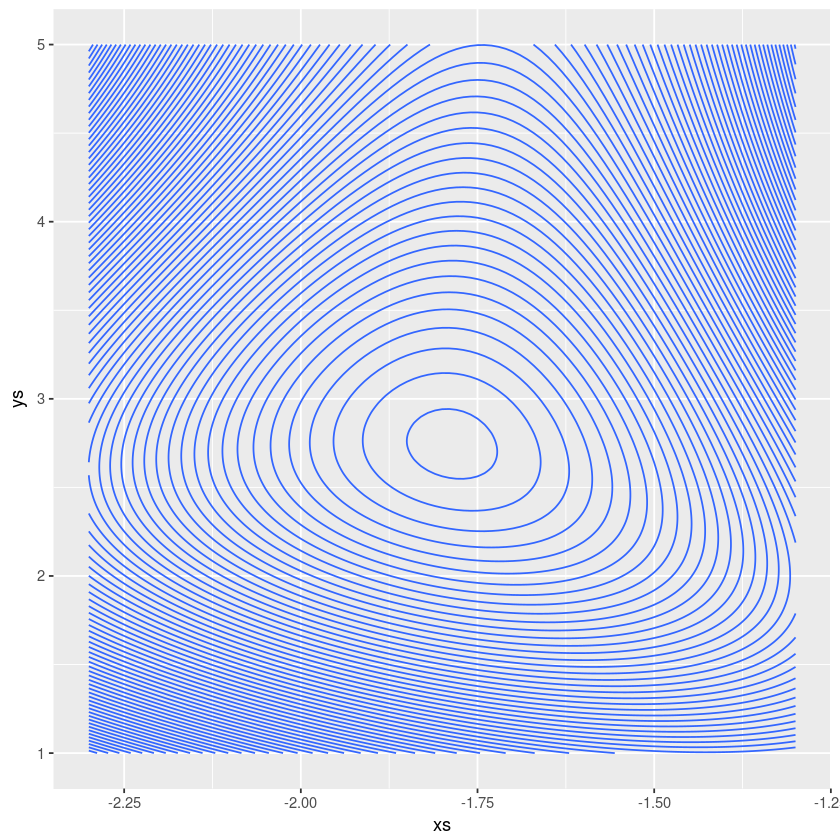

In [41]:
ggplot(points) +
    aes(x=xs, y=ys, z=transformedLogPost) +
    geom_contour(binwidth=0.5)

The way that R generates contours is a bit different, but we can see that the plot has (close to?) the same mode and shape as Figure 5.3 in Gelman et al.

## Inference for Parameter Values

Now we want to infer parameter values.

Let us first normalize the posterior likelihoods to something we can actually exponentiate.

In [42]:
normPost = points$transformedLogPost - max(points$transformedLogPost)
summary(normPost)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-34.640 -13.330  -8.476  -9.560  -4.407   0.000 

Now estimate $E[\alpha]$; we divide by $\sum P(\alpha,\beta|y)$ to obtain something like real probabilities:

In [43]:
exp.alpha = sum(points$alpha * exp(normPost)) / sum(exp(normPost))
exp.alpha

[1] 2.402562

This matches Gelman's value of $E[\alpha|y] \approx 2.4$. Let's try $\beta$.

In [44]:
exp.beta = sum(points$beta * exp(normPost)) / sum(exp(normPost))
exp.beta

[1] 14.31947

This is Gelman's value as well ($E[\beta|y] \approx 14.3$). What are the x and y values that arise from this?

In [45]:
y = log(exp.alpha + exp.beta)
y

[1] 2.816727

In [46]:
x = log(exp.alpha / exp.beta)
x

[1] -1.785085

That aligns with the mode of our contour plot.

Now, what is the posterior expected value of $\theta$ based on pointwise estimates of $\alpha$ and $\beta$?  This can be computed with $\frac{\alpha}{\alpha + \beta}$.

In [47]:
exp.alpha / (exp.alpha + exp.beta)

[1] 0.1436764

This value lies between the mean rate (0.13) and the overall infection rate (0.15).

And a plot of the posterior distribution based on the pointwise estimates:

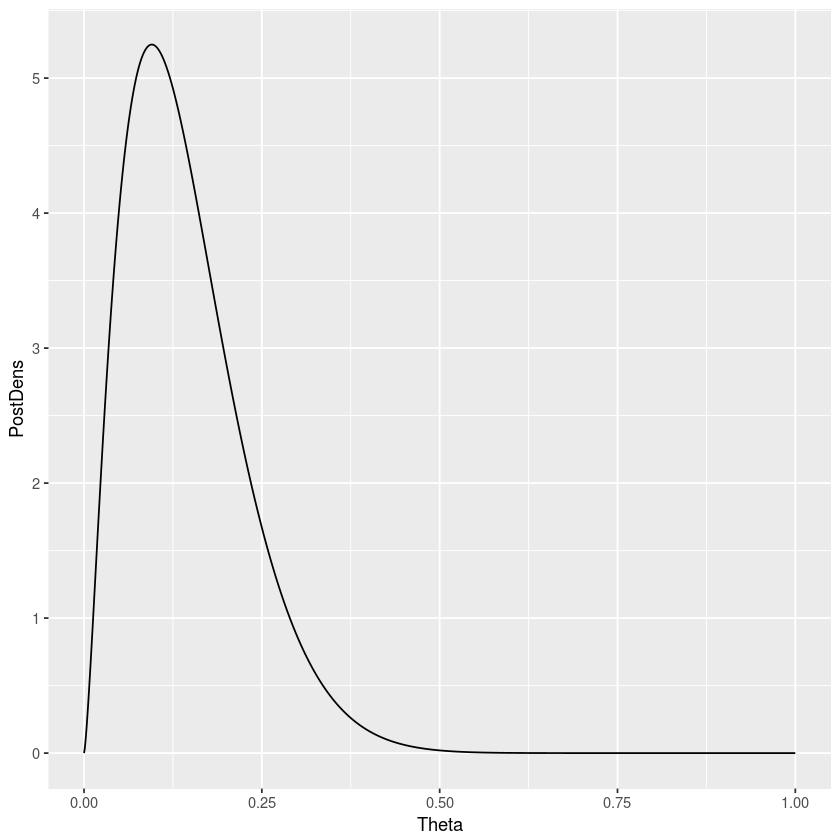

In [49]:
theta.post.point = data.frame(Theta=seq(0,1,0.001))
theta.post.point$PostDens = dbeta(theta.post.point$Theta, exp.alpha, exp.beta)
ggplot(theta.post.point) + aes(x=Theta, y=PostDens) + geom_line()

## Advanced Inference

Let's do some more advanced inference of the posterior distribution.  We're going to use a log posterior normalization of +735 to get numbers to work out in a reasonable fashion.  This value is selected to bring the largest posterior log likelihood close to 0.

First, we will write a function to compute the probability density of a particular $\theta$, as an integral $P(\theta|\mathbf{y}) = \iint P(\theta|\alpha,\beta)P(\alpha,\beta|\mathbf{y}) \, \mathrm{d}\alpha \mathrm{d}\beta$.

In [30]:
theta.post = function(theta, loglike=rats_loglike, parallel=length(theta) > 10) {
    aaply(theta, 1, function(thv) {
        integrate(function(beta) {
            aaply(beta, 1, function(bv) {
                integrate(function(alpha) {
                    ll = loglike(alpha, bv, rat.data$Infected, rat.data$Total)
                    like = exp(ll + 735)
                    pth = dbeta(thv, alpha, bv)
                    pth * prior(alpha, bv) * like
                }, 0, Inf, rel.tol = 0.001)$value
                })
            }, 0, Inf, rel.tol = 0.001)$value
    }, .parallel=parallel)
}

Test this function with our observed mean $0.14$, using both log likelihood implementations.

In [31]:
theta.post(0.14, rats.loglike)

[1] 3.244171

In [32]:
theta.post(0.14, rats_loglike)

[1] 3.244171

Now, we want to plot the posterior density.  So we will compute our posterior density, with `theta.post` (the integral-based function), for a variety of $\theta$ values.  $\theta=0$ and $\theta=1$ are not well-formed, so we exclude them.

In [33]:
thetas.frame = data.frame(Theta=seq(0.01, 0.99, 0.001))
thetas.frame$PostDens = theta.post(thetas.frame$Theta)

Now we need to rescale the posterior densitites based on the total density.  This puts them into approximately the same scale as a real beta distribution probability density function.

We multiply the density by 0.001 and sum, to account for the fact that we are computing in intervals of 0.001.  A more refined estimate would take advantage of the trapezoid approximation of integration.

In [34]:
thetas.frame = thetas.frame %>% mutate(PostDens=PostDens/sum(PostDens * 0.001))

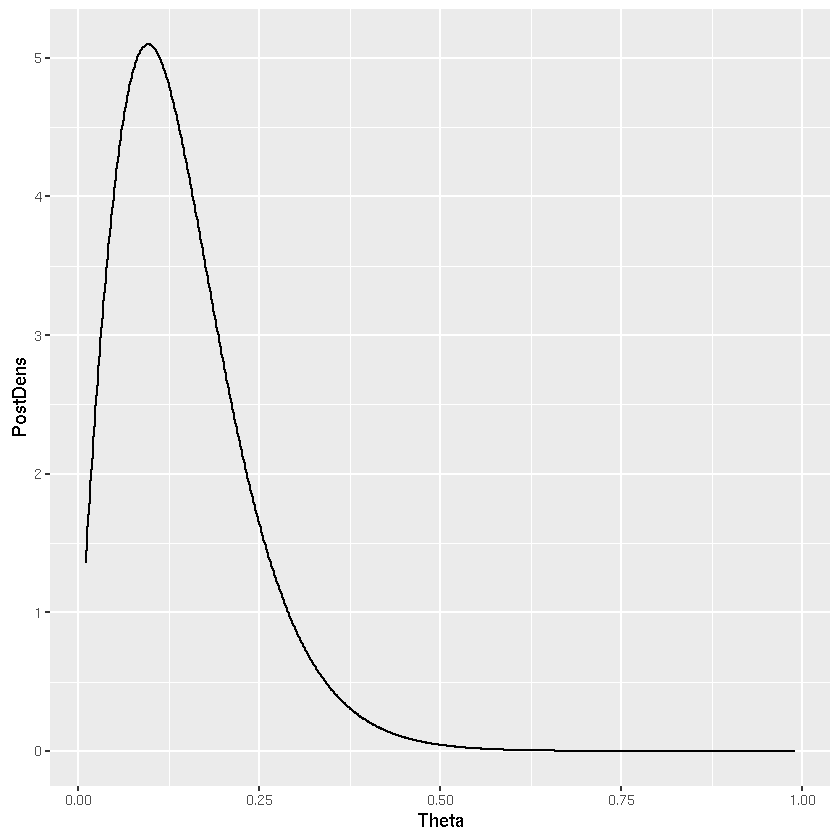

In [35]:
ggplot(thetas.frame) +
    aes(x=Theta, y=PostDens) +
    geom_line()

What is the expected value of $\theta$?  We will take the weighted mean.

In [36]:
sum(thetas.frame$Theta * thetas.frame$PostDens) / sum(thetas.frame$PostDens)

[1] 0.1453608

What is a 95% credible interval?

In [37]:
thetas.frame$CumDens = cumsum(thetas.frame$PostDens) / sum(thetas.frame$PostDens)
summary(thetas.frame)

     Theta          PostDens           CumDens       
 Min.   :0.010   Min.   :0.000000   Min.   :0.00136  
 1st Qu.:0.255   1st Qu.:0.000385   1st Qu.:0.88649  
 Median :0.500   Median :0.044177   Median :0.99752  
 Mean   :0.500   Mean   :1.019368   Mean   :0.86202  
 3rd Qu.:0.745   3rd Qu.:1.507541   3rd Qu.:0.99999  
 Max.   :0.990   Max.   :5.100291   Max.   :1.00000  

In [38]:
theta.ci.indexes = c(which(thetas.frame$CumDens >= 0.025)[1],
                     which(thetas.frame$CumDens >= 0.975)[1])
thetas.frame$Theta[theta.ci.indexes]

[1] 0.023 0.360

### Merging Plots

Now we will plot a single plot that has two versions of the posterior density: one based on pointwise estimates for the parameters $\alpha$ and $\beta$ of a beta distribution, and one with the posterior density integrated over all parameter values.

In [39]:
theta.post.merged = rbind(
    (theta.post.point %>% mutate(Method='Pointwise')),
    (thetas.frame %>% select(Theta, PostDens) %>% mutate(Method='Integral'))
)

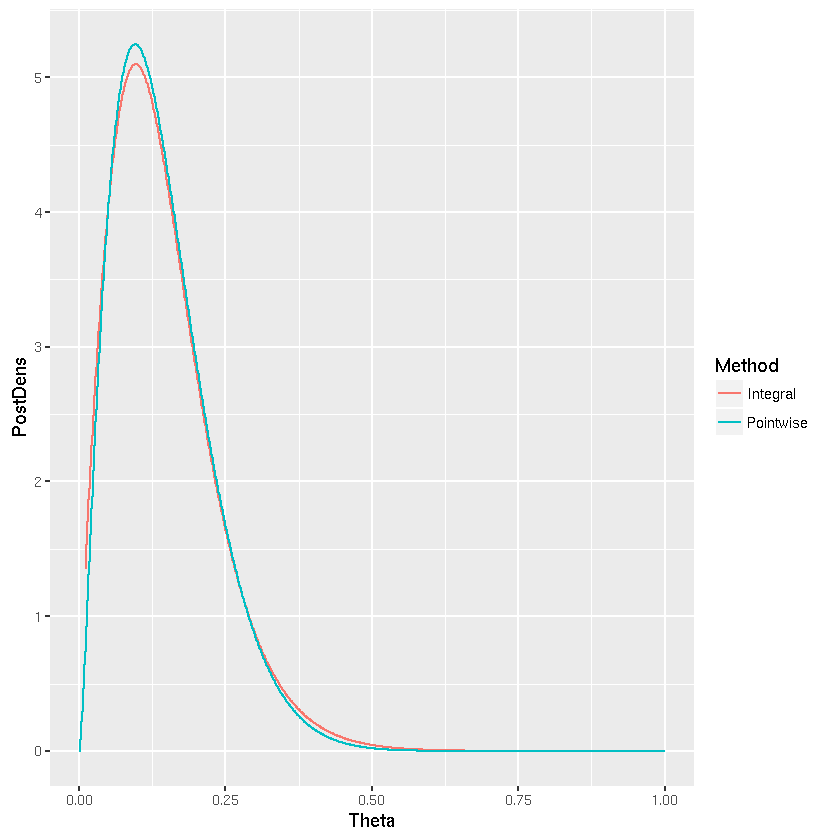

In [40]:
ggplot(theta.post.merged) +
    aes(x=Theta, y=PostDens, color=Method) +
    geom_line()

The peak is in about the same point. The integrated distribution is slightly broader.  However, the pointwise estimate is very close.